<a href="https://colab.research.google.com/github/farbowitz/MSc-Notebooks/blob/main/A2_KT_analysis_Farbowitz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **KT analysis**
*Dan Farbowitz*

A note book to explore clearness index calculation and distributions using pvlib.
Originally designed by Jamie Taylor, A Buckley

First Authored: 2019-11-05

Revised: 2020-11-23


Install python package

In [ ]:
!pip install numpy pandas>1.0 matplotlib pvlib geopy geocoder

Import modules. Note that at the moment the code to "mount" your google drive store as a drive where you can save data is commented out.

In [ ]:
from datetime import datetime as dt

from google.colab import drive
drive.mount('drive', force_remount=True)

import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib
from geopy.geocoders import Nominatim
import glob
import os
import json
import requests
import scipy.stats as sp
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 


Mounted at drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


We'll be using the inherent data from renewables ninja (index-based, unfortunately) to automate almost every relevant fact to solpos. This uses geopy to reverse-lookup the location from its (lat, long) coordinates given in the renewables ninja data.

Temperature will be averaged from temperature data later.

In [ ]:
#default data
altitude = 100
tz = "UTC"
temperature = 12


In [ ]:
#trying to import multiple Renewables Ninja data files into one dataframe


folder = '/content/drive/MyDrive/KT data' 

all_files = glob.glob(os.path.join(folder, '*.csv'))

li = {}
names = []
lat_data = []
long_data = []
for filename in all_files:
  
  #extracting relevant information from original RN file
  paraminfo = pd.read_csv(filename, header=2,index_col=0, parse_dates=True)
  latitude = round(float(list(paraminfo)[5][9:16]), 3)
  longitude = round(float(list(paraminfo)[6][9:16]), 3)
  #using lat/long data and geopy to lookup city by name
  geolocator = Nominatim(user_agent="geoapiExercises")
  try:
    city = geolocator.reverse(str(latitude)+","+str(longitude)).raw['address']['city']
  except KeyError:
    city = "("+str(latitude)+","+str(longitude)+")"

  #listing relevant dataset
  dataset = list(paraminfo)[9].replace(""" "dataset": """"", "")  #can I get out quotes?

  # import altitude data (will take a while): get_altitude(latitude, longitude)

  #time info from file
  df = pd.read_csv(filename, header=3,index_col=0, parse_dates=True)
  endyr = pd.DatetimeIndex(df.index).year[-1]
  startyr = pd.DatetimeIndex(df.index).year[0]
  #In case data spans multiple years
  if startyr == endyr:
    years = str(startyr)
  elif startyr < endyr:
    years = str(startyr) + '-' + str(endyr)
  else:
    years = str(startyr) +'?' + str(endyr)
  #elimniating extra 'Unnamed' columns
  for i in df.columns:
    if i[:2] == 'Un':
      df = df.drop([i], axis=1)
  # using file info to create index
  title = city + " " + years
  df.title = title
  df.latitude = latitude
  df.longitude = longitude
  li[title] = df


In [ ]:
#New Import Method for NSRDB data
folder = '/content/drive/MyDrive/KT data/NREL NSRDB Data' 

all_files = glob.glob(os.path.join(folder, '*.csv'))

li = {}

print(all_files)

for filename in all_files:
  
  #extracting relevant information from first 2 lines of original file
  paraminfo = pd.read_csv(filename, header=0,index_col=0, parse_dates=True)
  df = pd.read_csv(filename, header=2)
  #add in positional information to dataframe
  df.elevation = paraminfo['Elevation'][0]
  df.latitude = paraminfo['Latitude'][0]
  df.longitude = paraminfo['Longitude'][0]
  df['date'] = str(df['Year'] + '-' + df['Month'] + '-' + df['Day'] + " " + df['Hour'] + ":" + df['Minute'])
  print(df)

['/content/drive/MyDrive/KT data/NREL NSRDB Data/1338691_42.33_-71.10_1999.csv', '/content/drive/MyDrive/KT data/NREL NSRDB Data/1338691_42.33_-71.10_1998.csv', '/content/drive/MyDrive/KT data/NREL NSRDB Data/1338709_42.37_-71.10_2015.csv', '/content/drive/MyDrive/KT data/NREL NSRDB Data/1338691_42.33_-71.10_2018.csv', '/content/drive/MyDrive/KT data/NREL NSRDB Data/1338691_42.33_-71.10_2019.csv', '/content/drive/MyDrive/KT data/NREL NSRDB Data/1338709_42.37_-71.10_2005.csv', '/content/drive/MyDrive/KT data/NREL NSRDB Data/1338709_42.37_-71.10_2002.csv', '/content/drive/MyDrive/KT data/NREL NSRDB Data/1338709_42.37_-71.10_2012.csv', '/content/drive/MyDrive/KT data/NREL NSRDB Data/1338691_42.33_-71.10_2001.csv', '/content/drive/MyDrive/KT data/NREL NSRDB Data/1338691_42.33_-71.10_2012.csv', '/content/drive/MyDrive/KT data/NREL NSRDB Data/1338709_42.37_-71.10_2007.csv', '/content/drive/MyDrive/KT data/NREL NSRDB Data/1338691_42.33_-71.10_2010.csv', '/content/drive/MyDrive/KT data/NREL NS

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,45) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


ValueError: ignored

After getting the metadata, rereading the files into a dataframe with the appropriate headers.

In [ ]:
#time-based indices
def t_alt(short):
  if short == 'H':
    return 'Hourly'
  elif short == 'D':
    return 'Daily'
  elif short == 'W':
    return 'Weekly'
  elif short == 'M':
    return 'Monthly'
  elif short == 'Q':
    return 'Quarterly'
  elif short == 'Y':
    return 'Annual'
  else:
    return ''

Now lets simulate the extra-atmospheric irradiance for the timeseries that we have observation data for in the location of the observations. We start to use pvlib functions location.Location and solpos.

etr is the extraterrestrial solar radiation - but it is not corrected to the horizontal plane (etr_hor) at a particular latitude and longitude. To do this correction we need to know the zenith angle (zen) (which is contained within the solpos method).

In [ ]:
#looping data over time periods
def get_KT_Charts(dataset, interval): 
  #setting up info
  latitude = dataset.latitude
  longitude = dataset.longitude
  suptl = dataset.title
  dataset = dataset.tz_localize('UTC')
  temperature = dataset['temperature'].mean()
  start = dataset.index[0]
  end = dataset.index[-1]

  #using available information to get solar position
  times = pd.date_range(start = start, end = end, tz = tz, freq = 'H')
  loc = pvlib.location.Location(latitude = latitude, longitude = longitude, altitude=altitude)
  solpos = loc.get_solarposition(times, temperature)
  #calculating irradiance from solar position, including horizontal component by taking cos(zenith angle) of irradiance data
  etr = pvlib.irradiance.get_extra_radiation(times)
  zen = solpos["apparent_zenith"]
  etr_hor = np.cos(np.radians(zen)) * etr
  #setting negative values (nighttime 'irradiance') to 0
  etr_hor[etr_hor < 0] = 0
  #taking means over time interval
  etr_h_hor = etr_hor.resample(interval, label="left").mean()
  irr = dataset.radiation_surface.resample(interval, label = 'left').mean()
  #define KT, removing out of range samples (and 0 so nighttime doesn't overwhelm histogram)
  kt = irr / etr_h_hor
  kt[kt > 1.3] = np.nan
  kt[kt == 0] = np.nan
  #relabel for graphs
  t_int = t_alt(interval)
  if startyr == endyr:
    years = str(startyr)
  elif startyr < endyr:
    years = str(startyr) + '-' + str(endyr)
  else:
    years = str(startyr) +'?' + str(endyr)
  grid = plt.GridSpec(2, 2, wspace=0.4, hspace=0.4)
  plt.subplot(grid[0,:2])
  irr.plot(ylabel='Golbal Horizontal Irradiance (W/m^2)', xlabel='Date/Time', figsize = (10, 10))
  etr_h_hor.plot(ylabel='ET Horizontal Irradiance (W/m^2)', xlabel='Date/Time')
  
  plt.subplot(grid[1, 0])
  kt.plot(ylabel='KT Index', xlabel='Date/Time', ylim = (0, 1.4))
  
  plt.subplot(grid[1,1])
  plt.hist(kt[kt.notnull()], bins=130, range=(0,1.3))
  plt.xlabel('KT Index')
  plt.ylabel('Number of occurences')
  
  plt.suptitle(suptl + ' ' + t_int)
  plt.show()

#call up charts for each time interval based on city
def KT_loc(data):
  t_index = ['H', 'D', 'W', 'M', 'Q']
  for j in range(5):
    get_KT_Charts(data, t_index[j])



In [ ]:
def KT_chart(dataset, interval): 
  #setting up info
  latitude = dataset.latitude
  longitude = dataset.longitude
  suptl = dataset.title
  dataset = dataset.tz_localize('UTC')
  temperature = dataset['temperature'].mean()
  start = dataset.index[0]
  end = dataset.index[-1]

  #using available information to get solar position
  times = pd.date_range(start = start, end = end, tz = tz, freq = 'H')
  loc = pvlib.location.Location(latitude = latitude, longitude = longitude, altitude=altitude)
  solpos = loc.get_solarposition(times, temperature)
  #calculating irradiance from solar position, including horizontal component by taking cos(zenith angle) of irradiance data
  etr = pvlib.irradiance.get_extra_radiation(times)
  zen = solpos["apparent_zenith"]
  etr_hor = np.cos(np.radians(zen)) * etr
  #setting negative values (nighttime 'irradiance') to 0
  etr_hor[etr_hor < 0] = 0
  #taking means over time interval
  etr_h_hor = etr_hor.resample(interval, label="left").mean()
  irr = dataset.radiation_surface.resample(interval, label = 'left').mean()
  #define KT, removing out of range samples (and 0 so nighttime doesn't overwhelm histogram)
  kt = irr / etr_h_hor
  kt[kt > 1.3] = np.nan
  kt[kt == 0] = np.nan
  #relabel for graphs
  t_int = t_alt(interval)
  if startyr == endyr:
    years = str(startyr)
  elif startyr < endyr:
    years = str(startyr) + '-' + str(endyr)
  else:
    years = str(startyr) +'?' + str(endyr)
  kt.plot(ylabel='KT Index', xlabel='Date/Time', ylim = (0, 1.4))

Sheffield 2019
Boston 2019
Boston 2017
Boston 2018
Boston 2016
Boston 2015
34.354,-119.05 2017
34.354,-119.05 2018
34.324,-119.15 2016
المدينة المنورة 2015
Canberra 2019
Boston 2000
Boston 2001
Boston 2003
Boston 2002
Boston 2004
Boston 2005
Boston 2006
Boston 2007
Boston 2008
Boston 2009
Boston 2010
Boston 2011
Boston 2012
Boston 2013
Boston 2014


-71.058

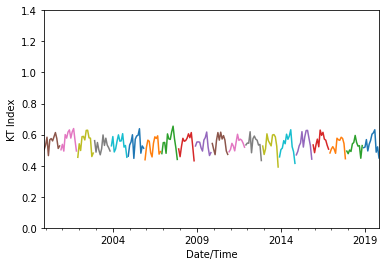

In [ ]:
for i in range(len(names)):
  latitude = lat_data[i]
  longitude = long_data[i]
  suptl = names[i]
  KT_loc(li[names[i]])

for i in li:
  if i.split(" ", 1)[0] == 'Boston':
    KT_chart(li[i], 'M')
  print(i)

li['Boston 2000'].longitude

Putting together all data sets for the same position across years. 

In [ ]:
def merge_years(lat, long):
  df = pd.DataFrame()
  for i in li:
    if lat == li[i].latitude and long == li[i].longitude:
      df = pd.concat([df, li[i]])
      df.title = li[i].title
      df.latitude = lat
      df.longitude = long
  df = df.sort_values(by='time')

  return df

merge_years(42.36, -71.058)

NameError: ignored

Now trying to chart KT info:


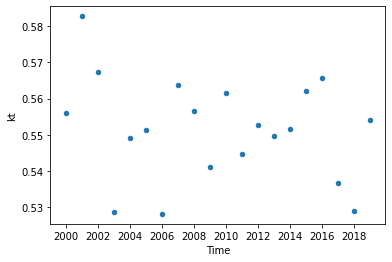

In [ ]:
def KT_data(lat, long, interval): 
  #setting up info
  latitude = lat
  longitude = long
  dataset = merge_years(latitude, longitude)
  dataset = dataset.tz_localize('UTC')
  temperature = dataset['temperature'].mean()
  start = dataset.index[0]
  end = dataset.index[-1]

  #using available information to get solar position
  times = pd.date_range(start = start, end = end, tz = tz, freq = 'H')
  loc = pvlib.location.Location(latitude = latitude, longitude = longitude, altitude=altitude)
  solpos = loc.get_solarposition(times, temperature)
  #calculating irradiance from solar position, including horizontal component by taking cos(zenith angle) of irradiance data
  etr = pvlib.irradiance.get_extra_radiation(times)
  zen = solpos["apparent_zenith"]
  etr_hor = np.cos(np.radians(zen)) * etr
  #setting negative values (nighttime 'irradiance') to 0
  etr_hor[etr_hor < 0] = 0
  #taking means over time interval
  etr_h_hor = etr_hor.resample(interval, label="left").mean()
  irr = dataset.radiation_surface.resample(interval, label = 'left').mean()
  #define KT, removing out of range samples (and 0 so nighttime doesn't overwhelm histogram)
  kt = irr / etr_h_hor
  kt[kt > 1.3] = np.nan
  kt[kt == 0] = np.nan
  #relabel for graphs
  kt.interval = t_alt(interval)
  if startyr == endyr:
    years = str(startyr)
  elif startyr < endyr:
    years = str(startyr) + '-' + str(endyr)
  else:
    years = str(startyr) +'?' + str(endyr)
  kt.years = years
  kt.lat = lat
  kt.long = long
  df = pd.DataFrame({'kt': kt, 'Time':kt.index})
  return df

boston = KT_data(42.36, -71.058, 'Y')
boston.plot.scatter(x='Time', y='kt')

In [ ]:
type(boston['Time'])

pandas.core.series.Series

In [ ]:
def doo(data):
  print(data.longitude)
doo(li['Boston 2019'])

-71.058



In and near Santa Paula, CA, in late 2017 into early 2018, there was a major forest fire (the Thomas Fire). In an attempt to see if such events were visible in the KT index, I printed out the data. Any effect is clearly not distinguishable from other noise in the KT data (e.g. cloud cover) An alternate explanation is that satellite data may not correctly reflect the global irradiance.

In [ ]:
df.to_csv('boston_hourly.csv')
!cp 'boston_hourly.csv' "drive/My Drive/colab_output/"

In [ ]:
def KT_Comparison(dataset, interval): 
  #setting up info
  latitude = dataset.latitude
  longitude = dataset.longitude
  suptl = dataset.title
  dataset = dataset.tz_localize('UTC')
  temperature = dataset['temperature'].mean()
  start = dataset.index[0]
  end = dataset.index[-1]

  #using available information to get solar position
  times = pd.date_range(start = start, end = end, tz = tz, freq = 'H')
  loc = pvlib.location.Location(latitude = latitude, longitude = longitude, altitude=altitude)
  solpos = loc.get_solarposition(times, temperature)
  #calculating irradiance from solar position, including horizontal component by taking cos(zenith angle) of irradiance data
  etr = pvlib.irradiance.get_extra_radiation(times)
  zen = solpos["apparent_zenith"]
  etr_hor = np.cos(np.radians(zen)) * etr
  #setting negative values (nighttime 'irradiance') to 0
  etr_hor[etr_hor < 0] = 0
  #taking means over time interval
  etr_h_hor = etr_hor.resample(interval, label="left").mean()
  irr = dataset.radiation_surface.resample(interval, label = 'left').mean()
  #define KT, removing out of range samples (and 0 so nighttime doesn't overwhelm histogram)
  kt = irr / etr_h_hor
  kt[kt > 1.3] = np.nan
  kt[kt == 0] = np.nan
  #relabel for graphs
  t_int = t_alt(interval)
  if startyr == endyr:
    years = str(startyr)
  elif startyr < endyr:
    years = str(startyr) + '-' + str(endyr)
  else:
    years = str(startyr) +'?' + str(endyr)
 
  
  plt.subplot()
  kt.plot(ylabel='KT Index', xlabel='Date/Time', ylim = (0, 1.4))
 
  plt.legend(title = 'Year')
  
  plt.suptitle(suptl + ' ' + t_int)
  plt.show()
